# 1. Imports

In [1]:
import pandas as pd
import asyncio
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import contractions
from googletrans import Translator
import json
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

from gensim.corpora import Dictionary

from gensim.models import LdaModel
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import pickle


import nest_asyncio
nest_asyncio.apply()

import nest_asyncio
nest_asyncio.apply()


# 2. Init

In [2]:
# Init Bahasa Indonesia stopwords
stpwds_id = stopwords.words('indonesian')

# init Sastrawi stemmer for Bahasa Indonesia
factory = StemmerFactory()
stemmer_id = factory.create_stemmer()

In [3]:
translator = Translator()

In [4]:
# Load the slang dictionary
with open('slang_bank.json', 'r') as file:
    slang_dict = json.load(file)

# 3. Compile datasets

In [5]:
# # combine the datasets
# # Define the folder path
# folder_path = './reviews'

# # Initialize an empty list to store dataframes
# dataframes = []

# # Iterate over all files in the folder
# for file_name in os.listdir(folder_path):
#     if file_name.endswith('.csv'):  # Check if the file is a CSV
#         file_path = os.path.join(folder_path, file_name)
#         # Read the CSV file into a dataframe
#         df = pd.read_csv(file_path)
#         # Optionally add a column to track the source file
#         df['Source'] = file_name
#         # Append the dataframe to the list
#         dataframes.append(df)

# # Combine all dataframes into a single dataframe
# combined_df = pd.concat(dataframes, ignore_index=True)

# # Save the combined dataframe to a CSV file
# output_path = 'compiled_reviews.csv'
# combined_df.to_csv(output_path, index=False)

# print(f"Combined dataframe saved to {output_path}")

# 4. Load Data

In [6]:
final_df = pd.read_csv('compiled_reviews.csv')

In [7]:
final_df

,Rating,Reviews,Date,Company,Province,Source
0,5,"Located at the Padang Old City area, just arou...",9 months ago,JNE,Aceh,JNE_Aceh.csv
1,1,"Bad service given to customers, my own experie...",4 years ago,JNE,Aceh,JNE_Aceh.csv
2,5,"Nice Place, they're working on rebuild their o...",3 years ago,JNE,Aceh,JNE_Aceh.csv
3,5,Good delivery service for customers in this co...,2 years ago,JNE,Aceh,JNE_Aceh.csv
4,5,Good service,3 years ago,JNE,Aceh,JNE_Aceh.csv
...,...,...,...,...,...,...
27160,1,No review found,NaN,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv
27161,1,No review found,NaN,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv
27162,1,No review found,NaN,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv
27163,2,No review found,NaN,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv


In [8]:
# remove rows with 'No review found'
final_df = final_df[final_df['Reviews'] != 'No review found']

In [9]:
final_df.shape

(18090, 6)

# 5. Parse date

In [10]:
# Calculate the mode of the 'Date' column
mode_value = final_df['Date'].mode()[0]

# Fill NaN values in the 'Date' column with the mode
final_df['Date'] = final_df['Date'].fillna(mode_value)

C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_16528\680656061.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Date'] = final_df['Date'].fillna(mode_value)


In [11]:
# let's translate the Date column to bahasa indonesia first
## def func to tran
async def translate_to_indonesian_async(text):
    try:
        translated = await translator.translate(text, src='auto', dest='id')
        return translated.text
    except Exception as e:
        print(f"Translation error: {e}")
        return text

In [12]:
# def tran
async def translate_column(df, column_name):
    tasks = [translate_to_indonesian_async(text) for text in df[column_name]]
    translated_texts = await asyncio.gather(*tasks)
    df[f"{column_name}_translated"] = translated_texts

In [13]:
# translating
await translate_column(final_df, "Date")

C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_16528\736067798.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{column_name}_translated"] = translated_texts


In [14]:
# let's attempt to transform the date
## def the func

def parse_time_ago(time_ago):
    current_time = datetime.now()
    
    # Match cases with explicit numbers
    match = re.match(r"(\d+)\s+(\w+)", time_ago)
    if match:
        value, unit = int(match.group(1)), match.group(2)
    else:
        # Handle "sehari", "seminggu", "sebulan", "setahun" cases
        if time_ago.startswith('se'):
            value, unit = 1, time_ago.split()[0][2:]  # Extract the unit after "se"
        else:
            return None  # If it doesn't match any known format, return None
    
    # Map units to timedelta
    if unit.startswith('menit'):
        return current_time - timedelta(minutes=value)
    elif unit.startswith('jam'):
        return current_time - timedelta(hours=value)
    elif unit.startswith('hari'):
        return current_time - timedelta(days=value)
    elif unit.startswith('minggu'):
        return current_time - timedelta(weeks=value)
    elif unit.startswith('bulan'):
        # Approximate 1 month = 30 days
        return current_time - timedelta(days=value * 30)
    elif unit.startswith('tahun'):
        # Approximate 1 year = 365 days
        return current_time - timedelta(days=value * 365)
    return None

In [15]:
final_df['parsed_date'] = final_df['Date_translated'].apply(parse_time_ago)

C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_16528\2538609799.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['parsed_date'] = final_df['Date_translated'].apply(parse_time_ago)


In [16]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18090 entries, 0 to 27084
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Rating           18090 non-null  int64         
 1   Reviews          18090 non-null  object        
 2   Date             18090 non-null  object        
 3   Company          18090 non-null  object        
 4   Province         18090 non-null  object        
 5   Source           18090 non-null  object        
 6   Date_translated  18090 non-null  object        
 7   parsed_date      18090 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 1.2+ MB


In [17]:
cleaned_df = final_df[['Rating', 'Reviews', 'Company', 'Province', 'parsed_date']]

In [18]:
# Standardize column names
cleaned_df.columns = cleaned_df.columns.str.strip().str.lower().str.replace(' ', '_')

In [19]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18090 entries, 0 to 27084
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   rating       18090 non-null  int64         
 1   reviews      18090 non-null  object        
 2   company      18090 non-null  object        
 3   province     18090 non-null  object        
 4   parsed_date  18090 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 848.0+ KB


In [20]:
# cleaned_df.to_csv('cleaned_reviews.csv', index=False)

# 6. Preprocessing

In [21]:
with open('exception_words.json', 'r') as file:
    exception_data = json.load(file)

# Extract the list of exception words
exception_words = set(exception_data["exception_words"])

In [22]:
with open('cleaned_reviews.csv', 'r') as file_cleaned:
    bersih_df = pd.read_csv(file_cleaned)

In [23]:
bersih_df

,rating,reviews,company,province,parsed_date
0,5,"Located at the Padang Old City area, just arou...",JNE,Aceh,2024-04-25 11:26:09.540805
1,1,"Bad service given to customers, my own experie...",JNE,Aceh,2021-01-21 11:26:09.540805
2,5,"Nice Place, they're working on rebuild their o...",JNE,Aceh,2022-01-21 11:26:09.540805
3,5,Good delivery service for customers in this co...,JNE,Aceh,2023-01-21 11:26:09.540805
4,5,Good service,JNE,Aceh,2022-01-21 11:26:09.540805
...,...,...,...,...,...
17659,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-21 11:26:09.574625
17660,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-21 11:26:09.574625
17661,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-21 11:26:09.574625
17662,1,KERAS!!!!!,Sicepat,Sumatera Utara,2021-01-21 11:26:09.574625


In [24]:
## reinit just to make sure

# Init Bahasa Indonesia stopwords
stpwds_id = stopwords.words('indonesian')

# init Sastrawi stemmer for Bahasa Indonesia
factory = StemmerFactory()
stemmer_id = factory.create_stemmer()

translator = Translator()

In [25]:
# Load the slang dictionary
with open('slang_bank.json', 'r') as file:
    slang_dict = json.load(file)

In [26]:
# Load additional stopwords
with open('expand_stopwords.json', 'r') as f:
    data = json.load(f)

# Ensure the key exists and is a list
custom_stopwords = data.get("expand_stopwords", [])
if not isinstance(custom_stopwords, list):
    raise ValueError("The 'expand_stopwords' key must contain a list.")

# Combine and ensure uniqueness
stpwds_id = set(stpwds_id)  # Convert existing stopwords to a set if not already
stpwds_id.update(custom_stopwords)  # Add new stopwords from the custom list

In [27]:
# let's redefine the func. cs it's so far above there....

async def text_preprocessing_id(text):
    
    # Translate to Bahasa Indonesia
    
    try:
        translated = await translator.translate(text, src='auto', dest='id')
        text = translated.text
    except Exception as e:
        print(f"Translation failed: {e}")
        return None  # Drop text if translation fails
    
    # Expand contractions
    text = contractions.fix(text)

    # Case folding
    text = text.lower()

    # Mention removal
    text = re.sub(r"@[A-Za-z0-9_]+", " ", text)

    # Hashtag removal
    text = re.sub(r"#[A-Za-z0-9_]+", " ", text)

    # Newline removal (\n)
    text = re.sub(r"\\n", " ", text)

    # Whitespace removal
    text = text.strip()

    # URL removal
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"www.\S+", " ", text)

    # Non-letter removal (retain apostrophes)
    text = re.sub(r"[^A-Za-z\s']", " ", text)
    
    # repeat letter removal
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Tokenization
    tokens = word_tokenize(text)
    
    # Slang words replacement
    tokens = [slang_dict[word] if word in slang_dict else word for word in tokens]

    # Stopwords removal
    ## btw itu bisa kalian bikin dict sendiri (.json , maybe).
    tokens = [word for word in tokens if word not in stpwds_id or word in exception_words]

    # Stemming (using Sastrawi for Bahasa Indonesia)
    tokens = [stemmer_id.stem(word) for word in tokens]

    # Combine tokens
    text = ' '.join(tokens)

    return text

In [28]:
# run it!
async def preprocess_reviews():
    bersih_df['processed_reviews'] = await asyncio.gather(
        *[text_preprocessing_id(review) for review in bersih_df['reviews']]
    )

await preprocess_reviews()

In [29]:
bersih_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17664 entries, 0 to 17663
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rating             17664 non-null  int64 
 1   reviews            17664 non-null  object
 2   company            17664 non-null  object
 3   province           17664 non-null  object
 4   parsed_date        17664 non-null  object
 5   processed_reviews  17664 non-null  object
dtypes: int64(1), object(5)
memory usage: 828.1+ KB


In [30]:
# Ensure the 'parsed_date' column is in datetime format
bersih_df['parsed_date'] = pd.to_datetime(bersih_df['parsed_date'])

# Extract only the date (remove the time)
bersih_df['parsed_date'] = bersih_df['parsed_date'].dt.date

In [31]:
# check nulls
bersih_df[bersih_df['processed_reviews'] == '']

,rating,reviews,company,province,parsed_date,processed_reviews
10,5,Ok,JNE,Aceh,2022-01-21,
15,5,24jam ready,JNE,Aceh,2020-01-22,
17,5,Great,JNE,Aceh,2019-01-22,
21,5,Ok,JNE,Aceh,2020-01-22,
23,4,Ok,JNE,Aceh,2020-01-22,
...,...,...,...,...,...,...
17444,1,Barang dari tanggal 1 sampe skrg belom terima ...,Sicepat,Sumatera Selatan,2021-01-21,
17445,5,baik,Sicepat,Sumatera Selatan,2021-01-21,
17464,1,babu,Sicepat,Sumatera Selatan,2021-01-21,
17643,1,Paket saya tambah jauh.,Sicepat,Sumatera Utara,2021-01-21,


In [32]:
bersih_df['rating'].value_counts()

rating
1    12456
5     2783
4      954
2      764
3      707
Name: count, dtype: int64

In [33]:
# bersih_df.to_csv('prepro_cleaned_reviews.csv', index=False)

# 7. EDA

In [34]:
with open('prepro_cleaned_reviews.csv', 'r') as file_prepro:
    eda_df = pd.read_csv(file_prepro)

In [35]:
eda_df['company'].value_counts()

company
JNE        7164
JNT        6545
Sicepat    3955
Name: count, dtype: int64

In [36]:
# Split DataFrame based on reviews column
jelek_eda_df = eda_df[eda_df['rating'] <= 3]  # Bad ratings (1 - 3)
bagus_eda_df = eda_df[eda_df['rating'] >= 4]  # Good ratings (4 or 5)

print(f"Bad reviews count: {jelek_eda_df.shape[0]}")
print(f"Good reviews count: {bagus_eda_df.shape[0]}")

Bad reviews count: 13927
Good reviews count: 3737


In [37]:
# Kalo mau per company, bagi tiga dulu: JNE, jnt, sicepat
jne_df = jelek_eda_df[jelek_eda_df['company'].str.lower() == 'jne']
jnt_df = jelek_eda_df[jelek_eda_df['company'].str.lower() == 'jnt']
sicepat_df = jelek_eda_df[jelek_eda_df['company'].str.lower() == 'sicepat']

In [38]:
jelek_eda_df

,rating,reviews,company,province,parsed_date,processed_reviews
1,1,"Bad service given to customers, my own experie...",JNE,Aceh,2021-01-21,layan buruk langgan alam ambil jasa kirim kelu...
7,1,Too slow,JNE,Aceh,2016-01-23,lambat
18,2,Slow service,JNE,Aceh,2022-01-21,lambat
20,1,Bad service,JNE,Aceh,2019-01-22,buruk
24,1,The courier was too slow for many reasons even...,JNE,Aceh,2025-01-06,kurir lambat kira pakai sayang m
...,...,...,...,...,...,...
17658,1,Lambat,Sicepat,Sumatera Utara,2021-01-21,lambat
17659,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-21,kargo lambat
17660,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-21,lambat cembret
17661,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-21,lambat


## a. WordClouds

In [39]:
# Function to generate and display word clouds
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

In [40]:
# gak boleh ada naan ternyata...

# Replace NaN with an empty string and ensure all values are strings
jne_df['processed_reviews'] = jne_df['processed_reviews'].fillna('').astype(str)
jnt_df['processed_reviews'] = jnt_df['processed_reviews'].fillna('').astype(str)
sicepat_df['processed_reviews'] = sicepat_df['processed_reviews'].fillna('').astype(str)

jelek_eda_df['processed_reviews'] = jelek_eda_df['processed_reviews'].fillna('').astype(str)

C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_16528\1329673354.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jne_df['processed_reviews'] = jne_df['processed_reviews'].fillna('').astype(str)
C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_16528\1329673354.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jnt_df['processed_reviews'] = jnt_df['processed_reviews'].fillna('').astype(str)
C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_16528\1329673354.py:6: SettingWithCopy

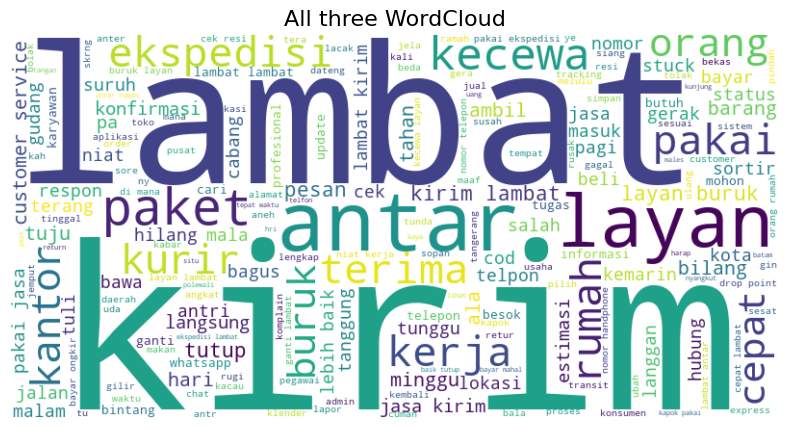

In [41]:
generate_wordcloud(jelek_eda_df['processed_reviews'], 'All three WordCloud')

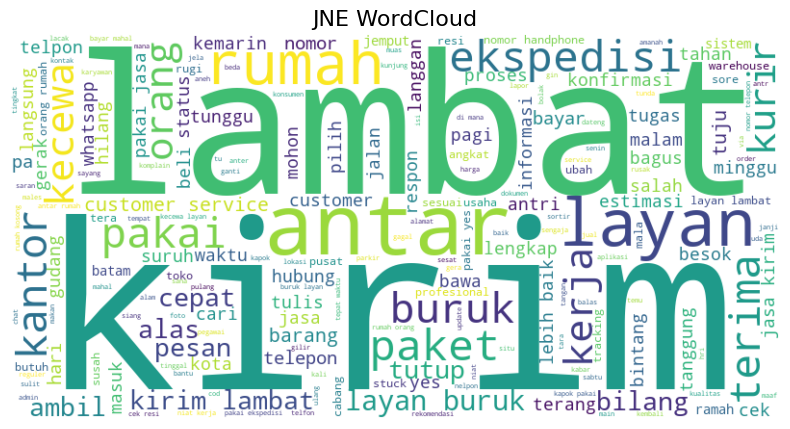

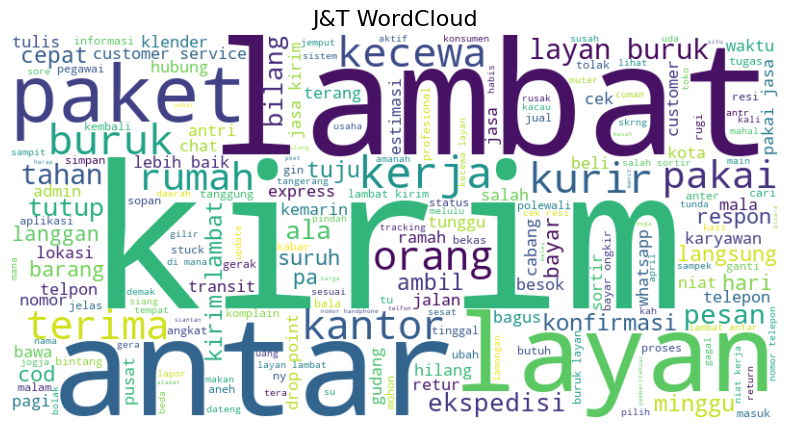

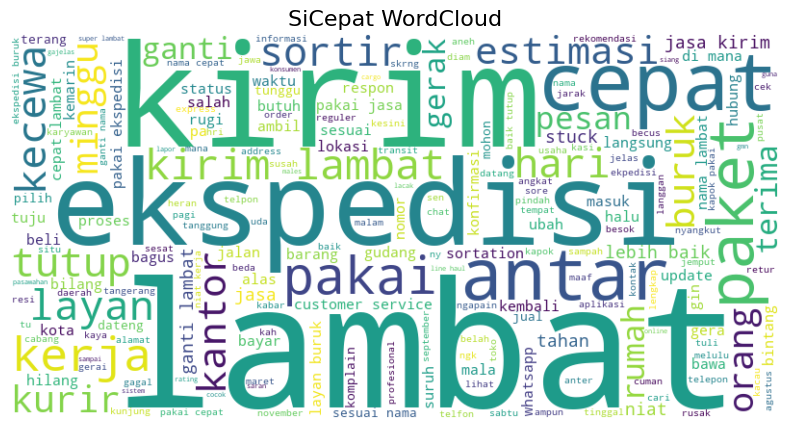

In [42]:
# Generate word clouds for each company
generate_wordcloud(jne_df['processed_reviews'], 'JNE WordCloud')
generate_wordcloud(jnt_df['processed_reviews'], 'J&T WordCloud')
generate_wordcloud(sicepat_df['processed_reviews'], 'SiCepat WordCloud')

In [43]:
# check most used stopwords
## def function

def analyze_most_used_words(df, column, top_n=20):
    '''
    Check n top_n of most common words used.
    df = data
    column = column to be processed
    top_n = show top n words 
    '''
    # Tokenize the column into words
    df['words_list'] = df[column].apply(lambda x: str(x).split())
    
    # Flatten the list of lists and count word frequencies
    word_counts = Counter([word for words in df['words_list'] for word in words])
    
    # Create a DataFrame with the top N most common words
    most_common_df = pd.DataFrame(word_counts.most_common(top_n), columns=['word', 'count'])
    
    # Display the table with a gradient background for visualization
    return most_common_df.style.background_gradient(cmap='Blues')

In [44]:
print("Most Used Words for all three:")
analyze_most_used_words(jelek_eda_df, 'processed_reviews')

Most Used Words for all three:


C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_16528\1013743734.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['words_list'] = df[column].apply(lambda x: str(x).split())


,word,count
0,kirim,4095
1,lambat,3781
2,layan,2352
3,antar,1694
4,pakai,1627
5,buruk,1594
6,ekspedisi,1290
7,rumah,1143
8,kantor,1104
9,kerja,1074


In [45]:
print("Most Used Words for JNE:")
analyze_most_used_words(jne_df, 'processed_reviews')

Most Used Words for JNE:


C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_16528\1013743734.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['words_list'] = df[column].apply(lambda x: str(x).split())


,word,count
0,kirim,1599
1,lambat,1098
2,layan,987
3,pakai,626
4,buruk,620
5,antar,612
6,rumah,605
7,kantor,463
8,ekspedisi,425
9,orang,385


In [46]:
print("Most Used Words for J&T:")
analyze_most_used_words(jnt_df, 'processed_reviews')

Most Used Words for J&T:


C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_16528\1013743734.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['words_list'] = df[column].apply(lambda x: str(x).split())


,word,count
0,kirim,1541
1,lambat,1186
2,layan,1123
3,antar,727
4,buruk,725
5,kerja,544
6,pakai,509
7,kantor,463
8,paket,442
9,kecewa,430


In [47]:
print("Most Used Words for SiCepat:")
analyze_most_used_words(sicepat_df, 'processed_reviews')

Most Used Words for SiCepat:


C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_16528\1013743734.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['words_list'] = df[column].apply(lambda x: str(x).split())


,word,count
0,lambat,1497
1,kirim,955
2,cepat,617
3,ekspedisi,555
4,pakai,492
5,antar,355
6,jasa,279
7,paket,252
8,buruk,249
9,layan,242


## b. bi/tri grams

In [48]:
# bigrams trigrams func

def get_ngrams(df, column, ngram_range, max_features=10):
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
    ngrams = vectorizer.fit_transform(df[column])
    return vectorizer.get_feature_names_out()

In [49]:
for company in jelek_eda_df['company'].str.lower().unique():
    print(f"\nTop 10 BIgrams for {company}:")
    bigrams = get_ngrams(jelek_eda_df[jelek_eda_df['company'].str.lower() == company], 'processed_reviews', (2, 2))
    print(bigrams)
    
    print(f"\nTop 10 TRIgrams for {company}:")
    trigrams = get_ngrams(jelek_eda_df[jelek_eda_df['company'].str.lower() == company], 'processed_reviews', (3, 3))
    print(trigrams)


Top 10 BIgrams for jne:
['customer service' 'jasa kirim' 'kirim lambat' 'lambat kirim'
 'layan buruk' 'lebih baik' 'nomor handphone' 'orang rumah' 'pakai jasa'
 'pakai yes']

Top 10 TRIgrams for jne:
['buruk kirim lambat' 'customer service pusat' 'layan buruk kirim'
 'lebih baik pakai' 'lebih baik tutup' 'makan gaji buta' 'nobody at home'
 'pakai jasa kirim' 'rumah kantor kosong' 'rumah kosong rumah']

Top 10 BIgrams for jnt:
['bayar ongkir' 'customer service' 'drop point' 'jasa kirim'
 'kirim lambat' 'lambat kirim' 'layan buruk' 'lebih baik' 'niat kerja'
 'pakai jasa']

Top 10 TRIgrams for jnt:
['bayar ongkir mahal' 'jasa kirim buruk' 'kapok pakai jasa'
 'layan buruk kirim' 'layan buruk kurir' 'lebih baik pakai'
 'lebih baik tutup' 'makan gaji buta' 'pakai jasa kirim'
 'telepon customer service']

Top 10 BIgrams for sicepat:
['cepat lambat' 'customer service' 'ganti lambat' 'jasa kirim'
 'kirim lambat' 'lambat kirim' 'layan buruk' 'lebih baik'
 'pakai ekspedisi' 'pakai jasa']

Top 10

# 8. Features Preparation

In [50]:
with open('prepro_cleaned_reviews.csv', 'r') as file_prepro:
    eda_df = pd.read_csv(file_prepro)

In [51]:
df = pd.read_csv('prepro_cleaned_reviews.csv')

In [52]:
df

,rating,reviews,company,province,parsed_date,processed_reviews
0,5,"Located at the Padang Old City area, just arou...",JNE,Aceh,2024-04-25,letak kawasan kota tua jembatan siti nurbaya s...
1,1,"Bad service given to customers, my own experie...",JNE,Aceh,2021-01-21,layan buruk langgan alam ambil jasa kirim kelu...
2,5,"Nice Place, they're working on rebuild their o...",JNE,Aceh,2022-01-21,bagus upaya bangun kantor orang orang hebat layan
3,5,Good delivery service for customers in this co...,JNE,Aceh,2023-01-21,kirim langgan negara
4,5,Good service,JNE,Aceh,2022-01-21,layan bagus
...,...,...,...,...,...,...
17659,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-21,kargo lambat
17660,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-21,lambat cembret
17661,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-21,lambat
17662,1,KERAS!!!!!,Sicepat,Sumatera Utara,2021-01-21,keras


In [53]:
modeling_df = df.copy()

## a. Jelek Modeling

In [54]:
jelek_modeling = modeling_df.query("rating <= 3" )
bagus_modeling = modeling_df.query("rating >= 4")

In [55]:
print(jelek_modeling.shape)
print(bagus_modeling.shape)

(13927, 6)
(3737, 6)


In [56]:
# Ensure the 'processed_reviews' column is treated as string
jelek_modeling['processed_reviews'] = jelek_modeling['processed_reviews'].astype(str)

# Tokenize the processed_reviews column
jelek_modeling['tokenized_reviews'] = jelek_modeling['processed_reviews'].apply(word_tokenize)

C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_16528\2846537713.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jelek_modeling['processed_reviews'] = jelek_modeling['processed_reviews'].astype(str)
C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_16528\2846537713.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jelek_modeling['tokenized_reviews'] = jelek_modeling['processed_reviews'].apply(word_tokenize)


In [57]:
jelek_modeling

,rating,reviews,company,province,parsed_date,processed_reviews,tokenized_reviews
1,1,"Bad service given to customers, my own experie...",JNE,Aceh,2021-01-21,layan buruk langgan alam ambil jasa kirim kelu...,"[layan, buruk, langgan, alam, ambil, jasa, kir..."
7,1,Too slow,JNE,Aceh,2016-01-23,lambat,[lambat]
18,2,Slow service,JNE,Aceh,2022-01-21,lambat,[lambat]
20,1,Bad service,JNE,Aceh,2019-01-22,buruk,[buruk]
24,1,The courier was too slow for many reasons even...,JNE,Aceh,2025-01-06,kurir lambat kira pakai sayang m,"[kurir, lambat, kira, pakai, sayang, m]"
...,...,...,...,...,...,...,...
17658,1,Lambat,Sicepat,Sumatera Utara,2021-01-21,lambat,[lambat]
17659,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-21,kargo lambat,"[kargo, lambat]"
17660,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-21,lambat cembret,"[lambat, cembret]"
17661,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-21,lambat,[lambat]


In [58]:
tokenized_reviews = jelek_modeling['tokenized_reviews'].tolist()  # Convert the column to a list of lists
dictionary = Dictionary(tokenized_reviews)

In [59]:
# Print dictionary information
print(f"Dictionary created with {len(dictionary)} unique tokens.")

Dictionary created with 10834 unique tokens.


In [60]:
# Word counts
word_counts = dictionary.cfs  # cfs = term frequency across the corpus
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

In [61]:
# Cumulative frequency
word_frequencies = [count for _, count in sorted_word_counts]
cumulative_frequencies = [sum(word_frequencies[:i]) for i in range(1, len(word_frequencies) + 1)]

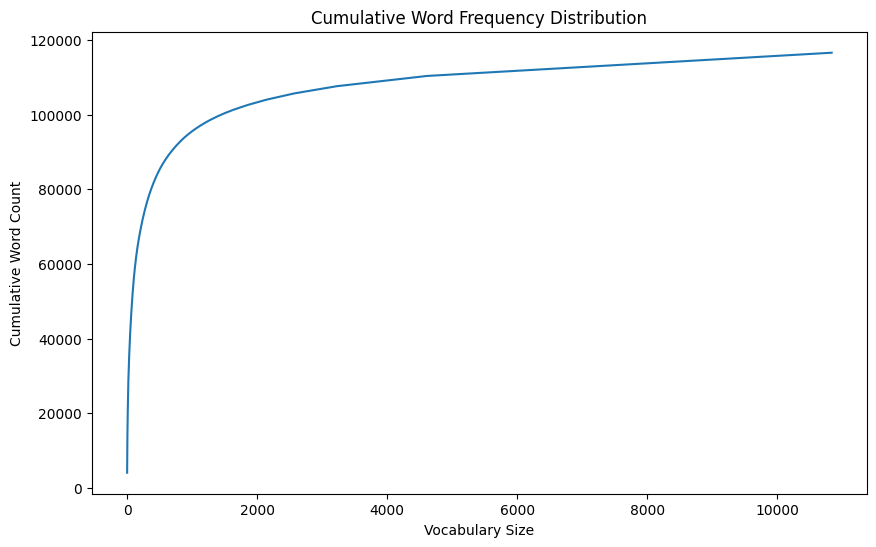

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_frequencies) + 1), cumulative_frequencies)
plt.xlabel('Vocabulary Size')
plt.ylabel('Cumulative Word Count')
plt.title('Cumulative Word Frequency Distribution')
plt.show()

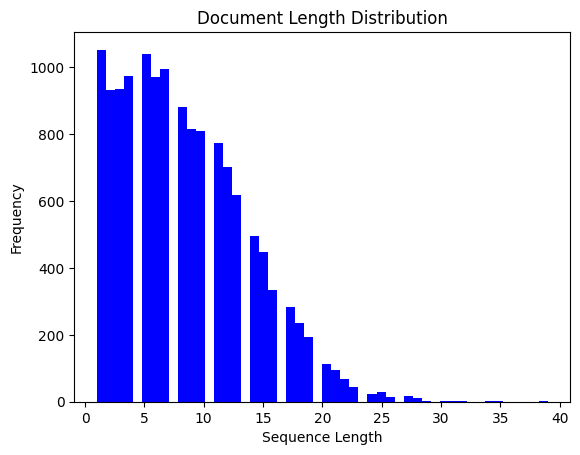

count    13927.000000
mean         8.373160
std          5.362486
min          1.000000
25%          4.000000
50%          8.000000
75%         12.000000
90%         16.000000
95%         18.000000
max         39.000000
Name: tokenized_reviews, dtype: float64


In [63]:
sequence_lengths = jelek_modeling['tokenized_reviews'].apply(len)

# Plot sequence length distribution
plt.hist(sequence_lengths, bins=50, color='blue')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Document Length Distribution')
plt.show()

# Print descriptive stats
print(sequence_lengths.describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95]))

In [64]:
top_n = 5000  # Adjust berdasarkan "Cumulative Word Frequency Distribution"
word_coverage = sum([freq for _, freq in sorted_word_counts[:top_n]]) / sum(word_frequencies)
print(f"Word Coverage with top {top_n} words: {word_coverage:.2%}")

Word Coverage with top 5000 words: 95.00%


In [65]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=5000)
print(f"Filtered dictionary size: {len(dictionary)}")

Filtered dictionary size: 2039


In [66]:
# bikin bag of words
corpus = [dictionary.doc2bow(review) for review in tokenized_reviews]

In [67]:
lda_model = LdaModel(corpus=corpus, 
                     id2word=dictionary,
                     alpha='auto',
                     eta='auto',
                     iterations=200, 
                     num_topics=3, 
                     chunksize=500, 
                     passes=100, 
                     random_state=37)

In [68]:
for i, topic in lda_model.show_topics(num_topics=4, num_words=30, formatted=False):
    print(f"Topic {i + 1}:")
    print(" ".join([word for word, _ in topic]))
    print()

Topic 1:
layan buruk kerja tutup ganti customer baik alas bayar service niat lebih suruh ambil malas beli kembali pusat cod pagi rugi langgan cabang jual mahal ongkir ramah nan profesional pindah

Topic 2:
lambat kirim pakai antar ekspedisi cepat paket jasa kecewa sortir estimasi pesan tuju hari tahan minggu nama kota sesuai waktu barang jalan gerak salah respon butuh bagus stuck hilang tunggu

Topic 3:
kantor rumah orang nomor kurir terima telepon bilang langsung cek konfirmasi resi pas telpon whatsapp mana bawa hubung masuk terang cari tulis angkat di informasi handphone aplikasi jemput sopan tu



In [69]:
coherence_model = CoherenceModel(model=lda_model, texts=jelek_modeling['tokenized_reviews'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

In [70]:
print(f"Coherence Score: {coherence_score}")

Coherence Score: 0.45900820455701735


In [71]:
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

In [72]:
# assign label per topic
topic_labels = {
    0: "Kualitas Pelayan Buruk",
    1: "Delay/ Lambat Pengiriman",
    2: "Komunikasi Kurir"
}

In [73]:
# Assign labels to documents
doc_topics = [max(lda_model.get_document_topics(doc), key=lambda x: x[1])[0] for doc in corpus]
jelek_modeling['topic'] = [topic_labels[topic] for topic in doc_topics]

C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_16528\3944936635.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jelek_modeling['topic'] = [topic_labels[topic] for topic in doc_topics]


In [74]:
# # Save labeled documents
# jelek_modeling.to_csv("labeled_documents.csv", index=False)

In [75]:
jelek_modeling['topic'].value_counts()

topic
Delay/ Lambat Pengiriman    10113
Kualitas Pelayan Buruk       2232
Komunikasi Kurir             1582
Name: count, dtype: int64

In [76]:
jelek_modeling['company'].unique()

array(['JNE', 'JNT', 'Sicepat'], dtype=object)

## b. Bagus Modeling

In [77]:
bagus_modeling

,rating,reviews,company,province,parsed_date,processed_reviews
0,5,"Located at the Padang Old City area, just arou...",JNE,Aceh,2024-04-25,letak kawasan kota tua jembatan siti nurbaya s...
2,5,"Nice Place, they're working on rebuild their o...",JNE,Aceh,2022-01-21,bagus upaya bangun kantor orang orang hebat layan
3,5,Good delivery service for customers in this co...,JNE,Aceh,2023-01-21,kirim langgan negara
4,5,Good service,JNE,Aceh,2022-01-21,layan bagus
5,5,Very nice building and nice staff,JNE,Aceh,2023-01-21,bangun bagus staf
...,...,...,...,...,...,...
17647,5,Komplek pergudangan 👍👍 …,Sicepat,Sumatera Utara,2021-01-21,komplek gudang
17650,5,Semangat,Sicepat,Sumatera Utara,2021-01-21,semangat
17655,5,Kerja bagus,Sicepat,Sumatera Utara,2021-01-21,kerja bagus
17656,5,Bagus,Sicepat,Sumatera Utara,2021-01-21,bagus


In [78]:
bagus_modeling['rating'].value_counts()

rating
5    2783
4     954
Name: count, dtype: int64

In [79]:
# Ensure the 'processed_reviews' column is treated as string
bagus_modeling['processed_reviews'] = bagus_modeling['processed_reviews'].astype(str)

# Tokenize the processed_reviews column
bagus_modeling['tokenized_reviews'] = bagus_modeling['processed_reviews'].apply(word_tokenize)

C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_16528\1594058256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bagus_modeling['processed_reviews'] = bagus_modeling['processed_reviews'].astype(str)
C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_16528\1594058256.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bagus_modeling['tokenized_reviews'] = bagus_modeling['processed_reviews'].apply(word_tokenize)


In [80]:
tokenized_reviews2 = bagus_modeling['tokenized_reviews'].tolist()  # Convert the column to a list of lists
dictionary2 = Dictionary(tokenized_reviews2)

In [81]:
# Print dictionary information
print(f"Dictionary created with {len(dictionary2)} unique tokens.")

Dictionary created with 2922 unique tokens.


In [82]:
# Word counts
word_counts2 = dictionary2.cfs  # cfs = term frequency across the corpus
sorted_word_counts2 = sorted(word_counts2.items(), key=lambda x: x[1], reverse=True)

In [83]:
# Cumulative frequency
word_frequencies2 = [count for _, count in sorted_word_counts2]
cumulative_frequencies2 = [sum(word_frequencies2[:i]) for i in range(1, len(word_frequencies2) + 1)]

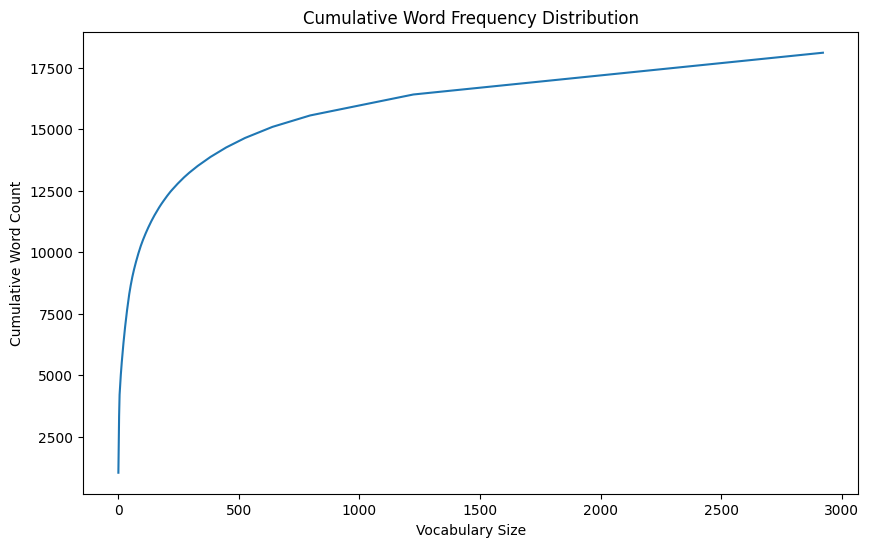

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_frequencies2) + 1), cumulative_frequencies2)
plt.xlabel('Vocabulary Size')
plt.ylabel('Cumulative Word Count')
plt.title('Cumulative Word Frequency Distribution')
plt.show()

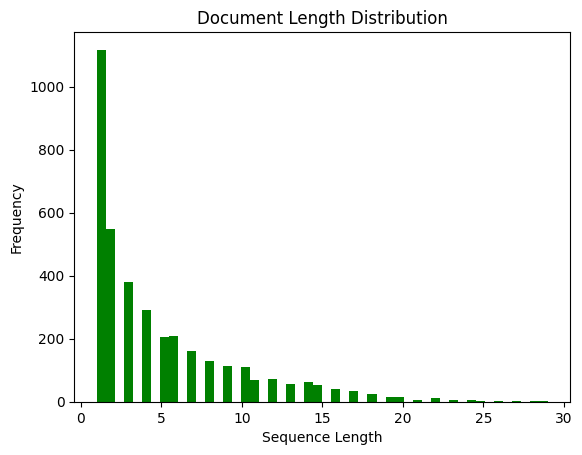

count    3737.000000
mean        4.846936
std         4.703649
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
90%        12.000000
95%        15.000000
max        29.000000
Name: tokenized_reviews, dtype: float64


In [85]:
sequence_lengths2 = bagus_modeling['tokenized_reviews'].apply(len)

# Plot sequence length distribution
plt.hist(sequence_lengths2, bins=50, color='green')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Document Length Distribution')
plt.show()

# Print descriptive stats
print(sequence_lengths2.describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95]))

In [86]:
top_n2 = 1250  # Adjust berdasarkan "Cumulative Word Frequency Distribution"
word_coverage2 = sum([freq for _, freq in sorted_word_counts2[:top_n2]]) / sum(word_frequencies2)
print(f"Word Coverage with top {top_n2} words: {word_coverage2:.2%}")

Word Coverage with top 1250 words: 90.77%


In [87]:
dictionary2.filter_extremes(no_below=5, no_above=0.5, keep_n=1250)
print(f"Filtered dictionary size: {len(dictionary2)}")

Filtered dictionary size: 500


In [88]:
# bikin bag of words
corpus2 = [dictionary2.doc2bow(review) for review in tokenized_reviews2]

In [89]:
lda_model_bagus = LdaModel(corpus=corpus2, 
                     id2word=dictionary2,
                     alpha='auto',
                     eta='auto',
                     iterations=100, 
                     num_topics=3, 
                     chunksize=500, 
                     passes=80, 
                     random_state=37)

In [90]:
for i, topic in lda_model_bagus.show_topics(num_topics=3, num_words=30, formatted=False):
    print(f"Topic {i + 1}:")
    print(" ".join([word for word, _ in topic]))
    print()

Topic 1:
layan cepat bagus kirim ramah lambat kantor pakai waktu jasa antar langsung ekspedisi rumah nyaman kota sesuai moga tepat mudah ambil aman tempat muas kurir customer langgan lokasi paket bantu

Topic 2:
baik kerja bintang pesan nama online percaya utama pagi hari ongkir telepon pilih jual reguler mohon profesional rating daerah besok belanja pindah komplain siang kemarin buruk wilayah beli indonesia senin

Topic 3:
nan parkir respon orang luas staf nomor masuk bayar proses antri ruang cari gudang beda gratis sedia sayang cek enak mobil handphone fast admin whatsapp via motor sehat semangat jaga



In [91]:
coherence_model2 = CoherenceModel(model=lda_model_bagus, texts=bagus_modeling['tokenized_reviews'], dictionary=dictionary2, coherence='c_v')
coherence_score2 = coherence_model2.get_coherence()

In [92]:
print(f"Coherence Score: {coherence_score2}")

Coherence Score: 0.44461283278991903


In [93]:
vis2 = gensimvis.prepare(lda_model_bagus, corpus2, dictionary2)
pyLDAvis.display(vis)

In [94]:
# assign label per topic
topic_labels_bagus = {
    0: "Pelayanan Bagus",
    1: "Kantor Cabang",
    2: "Respon Staff"
}

In [95]:
# Assign labels to documents
doc_topics = [max(lda_model_bagus.get_document_topics(doc), key=lambda x: x[1])[0] for doc in corpus2]
bagus_modeling['topic'] = [topic_labels_bagus[topic] for topic in doc_topics]

C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_16528\2970947602.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bagus_modeling['topic'] = [topic_labels_bagus[topic] for topic in doc_topics]


In [96]:
bagus_modeling['topic'].value_counts()

topic
Pelayanan Bagus    3711
Respon Staff         14
Kantor Cabang        12
Name: count, dtype: int64

In [97]:
# bagus_modeling.to_csv("bagus_labeled_documents.csv", index=False)

# 9. Saving the models

## a. Jelek Modeling

In [98]:
# # buruk_modeling
# lda_model.save('jelek_lda_model.model')

# print("LDA model saved as 'jelek_lda_model.model'")

In [99]:
# # Save the dictionary
# dictionary.save('jelek_lda_dictionary.dict')

# # Save the corpus
# with open('jelek_lda_corpus.pkl', 'wb') as f:
#     pickle.dump(corpus, f)

# print("Dictionary and corpus saved.")

## b. Bagus Modeling

In [100]:
# # buruk_modeling
# lda_model_bagus.save('bagus_lda_model.model')

# print("LDA model saved as 'bagus_lda_model.model'")

In [101]:
# # Save the dictionary
# dictionary2.save('bagus_lda_dictionary.dict')

# # Save the corpus
# with open('bagus_lda_corpus.pkl', 'wb') as f:
#     pickle.dump(corpus2, f)

# print("Dictionary and corpus saved.")